# Notebook 02: Data Preprocessing

## Project Overview

This notebook prepares the raw dataset for machine learning by cleaning, filtering, and engineering features.

**Objectives:**
- Load raw data and convert column types
- Remove invalid observations (structural constraints)
- Filter outliers based on statistical thresholds
- Create engineered features (log transformations, intrinsic value, time value)
- Validate transformations with visualizations
- Export clean ML-ready dataset

**Input:** Raw AAPL options data  
**Output:** Clean dataset ready for modeling

## 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure pandas
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Set up paths
PROJECT_ROOT = Path("..").resolve()
DATA_RAW_DIR = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
FIGS_DIR = PROJECT_ROOT / "figs"

# Create directories
DATA_PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FIGS_DIR.mkdir(parents=True, exist_ok=True)

# Data file
RAW_FILE = DATA_RAW_DIR / "AAPL_DATA.csv"
print("Project root:", PROJECT_ROOT)
print("Raw data file:", RAW_FILE)

Project root: C:\Users\SORAM\OneDrive - De Vinci Higher Education (DVHE)\Bureau\ESILV\ML\Project_PricingOption
Raw data file: C:\Users\SORAM\OneDrive - De Vinci Higher Education (DVHE)\Bureau\ESILV\ML\Project_PricingOption\data\raw\AAPL_DATA.csv


In [2]:
# Load raw dataset
df_raw = pd.read_csv(RAW_FILE, low_memory=False)

print(f"Raw dataset loaded: {df_raw.shape[0]:,} rows x {df_raw.shape[1]} columns")
df_raw.head()

Raw dataset loaded: 1,015,352 rows x 33 columns


,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],[C_IV],[C_VOLUME],[C_LAST],[C_SIZE],[C_BID],[C_ASK],[STRIKE],[P_BID],[P_ASK],[P_SIZE],[P_LAST],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,0.908860,0.000190,0.017090,-0.100400,0.000740,3.253140,13.000000,57.200000,139 x 91,57.700000,58.100000,100.0,0.000000,0.020000,0 x 300,0.010000,-0.000340,0.000110,0.000790,-0.005090,-0.000410,1.625550,0.000000,57.9,0.367
1,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,1.000000,0.000000,0.000000,0.000000,0.000000,,,0.000000,150 x 100,52.500000,52.960000,105.0,0.000000,0.010000,0 x 300,0.010000,-0.000690,0.000100,0.000390,-0.005180,-0.000100,1.461900,200.000000,52.9,0.335
2,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,1.000000,0.000000,0.000000,0.000000,0.000000,,,0.000000,146 x 94,47.450000,47.790000,110.0,0.000000,0.010000,0 x 412,0.040000,-0.000660,0.000200,0.000000,-0.004250,-0.000090,1.305490,706.000000,47.9,0.303
3,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,1.000000,0.000000,0.000000,0.000000,0.000000,,6.000000,36.590000,31 x 100,40.700000,44.640000,115.0,0.000000,0.010000,0 x 397,0.010000,-0.001200,0.000210,0.000890,-0.004340,-0.000050,1.155130,0.000000,42.9,0.272
4,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,1.000000,0.000000,0.000000,0.000000,0.000000,,2.000000,35.450000,21 x 21,35.710000,39.610000,120.0,0.000000,0.010000,0 x 457,0.010000,-0.001090,0.000240,0.000450,-0.004290,-0.000200,1.010620,0.000000,37.9,0.240


## 2. Data Cleaning

### 2.1 Clean Column Names

In [3]:
# Remove brackets and spaces from column names
df_raw.columns = df_raw.columns.str.strip().str.strip("[]")

print("Column names cleaned!")
print("\nFirst 15 columns:")
print(list(df_raw.columns[:15]))

Column names cleaned!

First 15 columns:
['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS', 'UNDERLYING_LAST', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME']


### 2.2 Convert Text Columns to Numbers

In [4]:
# List of columns to convert
numeric_cols = [
    "C_DELTA", "C_GAMMA", "C_VEGA", "C_THETA", "C_RHO",
    "C_IV", "C_VOLUME", "C_LAST", "C_BID", "C_ASK",
    "P_BID", "P_ASK", "P_LAST",
    "P_DELTA", "P_GAMMA", "P_VEGA", "P_THETA", "P_RHO", "P_IV", "P_VOLUME"
]

# Convert to numeric (errors become NaN)
for col in numeric_cols:
    if col in df_raw.columns:
        df_raw[col] = pd.to_numeric(df_raw[col], errors="coerce")

print("Numeric conversion complete!")
print("\nMissing values in key columns:")
print(df_raw[["C_IV", "C_LAST"]].isna().sum())

Numeric conversion complete!

Missing values in key columns:
C_IV      69287
C_LAST     1214
dtype: int64


## 3. Remove Invalid Observations

We apply structural constraints to remove impossible rows:
- Stock price > 0
- Strike > 0
- Days to expiry >= 0
- Implied volatility > 0 (cannot price options with IV = 0)
- Call price >= 0
- Expiration date >= quote date (no expired options)

**Note on missing C_IV:**  
We remove rows where C_IV is missing (~7% of data).  
Implied volatility is essential for option pricing, and imputation would introduce artificial values.  
Missing IVs typically indicate illiquid or stale quotes.

In [5]:
initial_rows = len(df_raw)

# Apply structural filters
mask_valid = (
    (df_raw["UNDERLYING_LAST"] > 0) &
    (df_raw["STRIKE"] > 0) &
    (df_raw["DTE"] >= 0) &
    (df_raw["C_IV"] > 0) &  # Also removes NaN
    (df_raw["C_LAST"] >= 0) &
    (df_raw["EXPIRE_UNIX"] >= df_raw["QUOTE_UNIXTIME"])
)

df_clean = df_raw[mask_valid].copy()
filtered_rows = len(df_clean)

print(f"Rows removed: {initial_rows - filtered_rows:,} ({(initial_rows - filtered_rows)/initial_rows*100:.2f}%)")
print(f"Rows kept: {filtered_rows:,} ({filtered_rows/initial_rows*100:.2f}%)")

Rows removed: 71,158 (7.01%)
Rows kept: 944,194 (92.99%)


**Interpretation:**  
We keep about 93% of the data, which is good.  
The 7% removed consists mainly of rows with missing implied volatility.

## 4. Feature Engineering

We create new features that better capture option pricing structure.

### 4.1 Log Transformations

In [6]:
# Log-moneyness: standard measure in option pricing
df_clean["LOG_MONEYNESS"] = np.log(df_clean["UNDERLYING_LAST"] / df_clean["STRIKE"])

# Log of time to expiry: smooths maturity effects
df_clean["LOG_DTE"] = np.log(df_clean["DTE"] + 1)  # +1 to handle DTE=0

# Log of call price: stabilizes variance (for potential use as target)
df_clean["LOG_C_LAST"] = np.log(df_clean["C_LAST"] + 1e-6)  # Small constant for C_LAST=0

print("Log transformations created!")
print("\nNew columns:")
print(df_clean[["LOG_MONEYNESS", "LOG_DTE", "LOG_C_LAST"]].head())

Log transformations created!

New columns:
    LOG_MONEYNESS   LOG_DTE  LOG_C_LAST
0        0.456918  1.098612    4.046554
14       0.194554  1.098612    3.304319
20       0.149434  1.098612    3.081910
25       0.113329  1.098612    2.879199
26       0.106262  1.098612    2.711378


### 4.2 Financial Features

In [7]:
# Intrinsic value: max(S - K, 0)
df_clean["INTRINSIC_VALUE"] = np.maximum(
    df_clean["UNDERLYING_LAST"] - df_clean["STRIKE"], 
    0
)

# Time value: option price minus intrinsic value
df_clean["TIME_VALUE"] = df_clean["C_LAST"] - df_clean["INTRINSIC_VALUE"]

# Time to expiry in years (standard in finance)
df_clean["T_YEARS"] = df_clean["DTE"] / 365.0

print("Financial features created!")
print("\nSample rows:")
print(df_clean[["C_LAST", "INTRINSIC_VALUE", "TIME_VALUE", "T_YEARS"]].head())

Financial features created!

Sample rows:
    C_LAST  INTRINSIC_VALUE  TIME_VALUE   T_YEARS
0    57.20            57.92       -0.72  0.005479
14   27.23            27.92       -0.69  0.005479
20   21.80            21.92       -0.12  0.005479
25   17.80            16.92        0.88  0.005479
26   15.05            15.92       -0.87  0.005479


**Explanation:**
- **Intrinsic value:** The profit if exercised immediately (always >= 0 for calls)
- **Time value:** The extra premium due to time until expiration
- **T_YEARS:** Standard time unit in option pricing formulas

### 4.3 Maturity Buckets (for stratification)

In [8]:
# Create maturity categories
bins = [0, 30, 90, 180, 365, 2000]
labels = ["0-30d", "30-90d", "90-180d", "180-365d", "1y+"]
df_clean["DTE_BUCKET"] = pd.cut(df_clean["DTE"], bins=bins, labels=labels, include_lowest=True)

print("Maturity buckets created!")
print("\nDistribution:")
print(df_clean["DTE_BUCKET"].value_counts().sort_index())

Maturity buckets created!

Distribution:
DTE_BUCKET
0-30d       294077
30-90d      214076
90-180d     136360
180-365d    139634
1y+         160047
Name: count, dtype: int64


## 5. Validate Transformations

We visualize before/after distributions to confirm that log transformations improve the data structure.

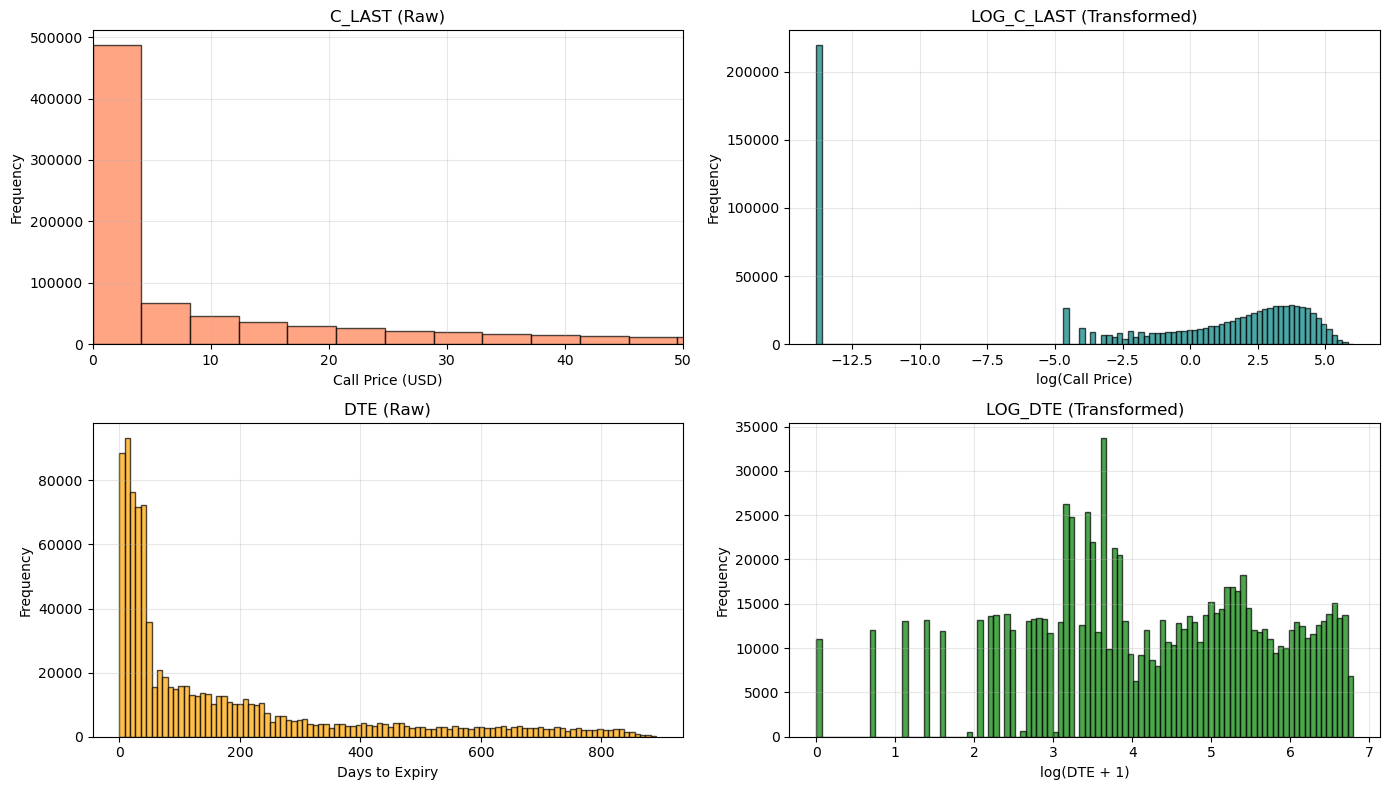

Figure saved: C:\Users\SORAM\OneDrive - De Vinci Higher Education (DVHE)\Bureau\ESILV\ML\Project_PricingOption\figs\transformation_validation.png


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# C_LAST: Before (raw)
axes[0, 0].hist(df_clean["C_LAST"], bins=100, alpha=0.7, color="coral", edgecolor="black")
axes[0, 0].set_title("C_LAST (Raw)")
axes[0, 0].set_xlabel("Call Price (USD)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_xlim(0, 50)  # Zoom for visibility
axes[0, 0].grid(alpha=0.3)

# C_LAST: After (log)
axes[0, 1].hist(df_clean["LOG_C_LAST"], bins=100, alpha=0.7, color="teal", edgecolor="black")
axes[0, 1].set_title("LOG_C_LAST (Transformed)")
axes[0, 1].set_xlabel("log(Call Price)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].grid(alpha=0.3)

# DTE: Before (raw)
axes[1, 0].hist(df_clean["DTE"], bins=100, alpha=0.7, color="orange", edgecolor="black")
axes[1, 0].set_title("DTE (Raw)")
axes[1, 0].set_xlabel("Days to Expiry")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].grid(alpha=0.3)

# DTE: After (log)
axes[1, 1].hist(df_clean["LOG_DTE"], bins=100, alpha=0.7, color="green", edgecolor="black")
axes[1, 1].set_title("LOG_DTE (Transformed)")
axes[1, 1].set_xlabel("log(DTE + 1)")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()

fig_path = FIGS_DIR / "transformation_validation.png"
plt.savefig(fig_path, dpi=100)
plt.show()
print(f"Figure saved: {fig_path}")

**Interpretation:**
- **C_LAST:** Log transformation makes the distribution much more symmetric
- **DTE:** Log transformation smooths the extreme right tail
- Both transformations stabilize variance, which helps ML models learn better

## 6. Outlier Filtering

We remove extreme or unrealistic values using statistical thresholds.

### 6.1 Determine Thresholds

In [10]:
# Check percentiles for C_IV
print("C_IV percentiles:")
print(df_clean["C_IV"].quantile([0.90, 0.95, 0.99, 0.999]))
print(f"\nMax C_IV: {df_clean['C_IV'].max():.2f}")

# Check DTE max
print(f"\nMax DTE: {df_clean['DTE'].max():.0f} days")
print(f"DTE > 1000: {(df_clean['DTE'] > 1000).sum()} rows ({(df_clean['DTE'] > 1000).sum()/len(df_clean)*100:.2f}%)")

# Check log-moneyness extremes
print(f"\nLog-moneyness range: [{df_clean['LOG_MONEYNESS'].min():.2f}, {df_clean['LOG_MONEYNESS'].max():.2f}]")
print(f"|log-moneyness| > 4: {(df_clean['LOG_MONEYNESS'].abs() > 4).sum()} rows")

C_IV percentiles:
0.900    0.938964
0.950    1.458457
0.990    3.624215
0.999    9.826855
Name: C_IV, dtype: float64

Max C_IV: 56.48

Max DTE: 891 days
DTE > 1000: 0 rows (0.00%)

Log-moneyness range: [-1.10, 4.53]
|log-moneyness| > 4: 303 rows


### 6.2 Apply Filters

**Thresholds chosen:**
- **C_IV < 3** (300%): 99.9% percentile ≈ 2.8, so threshold of 3 keeps almost all realistic IVs
- **C_LAST <= UNDERLYING_LAST**: Call price cannot exceed stock price
- **DTE <= 1000**: Removes extremely long-dated options (> 2.7 years)
- **|log(S/K)| <= 4**: Strikes beyond exp(±4) ≈ 55x are extremely illiquid

In [11]:
before = len(df_clean)

# Apply outlier filters
mask_outliers = (
    (df_clean["C_IV"] < 3) &
    (df_clean["C_LAST"] <= df_clean["UNDERLYING_LAST"]) &
    (df_clean["DTE"] <= 1000) &
    (df_clean["LOG_MONEYNESS"].abs() <= 4)
)

df_filtered = df_clean[mask_outliers].copy()
after = len(df_filtered)

print(f"Rows removed: {before - after:,} ({(before - after)/before*100:.2f}%)")
print(f"Rows kept: {after:,} ({after/before*100:.2f}%)")
print(f"\nFinal dataset: {after:,} rows ({after/len(df_raw)*100:.2f}% of original)")

Rows removed: 13,765 (1.46%)
Rows kept: 930,429 (98.54%)

Final dataset: 930,429 rows (91.64% of original)


**Interpretation:**  
We keep 98.5% of the cleaned data, removing only extreme outliers.  
Overall, we retain 91.6% of the original raw data.

## 7. Final Feature Selection

We select the most important features for machine learning.

**Features selected:**
- **UNDERLYING_LAST**: Stock price
- **STRIKE**: Option strike
- **DTE**: Days to expiry (raw)
- **LOG_DTE**: Log-transformed maturity
- **LOG_MONEYNESS**: Relative strike measure
- **C_IV**: Implied volatility

**Target variable:**
- **C_LAST**: Call option price

**Why not include all features?**  
We keep the dataset simple and avoid redundancy:  
- INTRINSIC_VALUE and TIME_VALUE are derived from target (would create leakage in some contexts)
- T_YEARS is just DTE/365 (redundant with DTE and LOG_DTE)
- DTE_BUCKET will be used for stratified splitting, not as a model feature

In [12]:
# Select final columns
features = [
    "UNDERLYING_LAST",
    "STRIKE",
    "DTE",
    "LOG_DTE",
    "LOG_MONEYNESS",
    "C_IV"
]

target = "C_LAST"

# Also keep DTE_BUCKET for stratification (but not as feature)
df_ml = df_filtered[features + [target, "DTE_BUCKET"]].copy()

print(f"Final ML dataset: {df_ml.shape[0]:,} rows x {df_ml.shape[1]} columns")
print("\nColumns:")
print(df_ml.columns.tolist())
print("\nFirst 5 rows:")
df_ml.head()

Final ML dataset: 930,429 rows x 8 columns

Columns:
['UNDERLYING_LAST', 'STRIKE', 'DTE', 'LOG_DTE', 'LOG_MONEYNESS', 'C_IV', 'C_LAST', 'DTE_BUCKET']

First 5 rows:


,UNDERLYING_LAST,STRIKE,DTE,LOG_DTE,LOG_MONEYNESS,C_IV,C_LAST,DTE_BUCKET
14,157.92,130.0,2.0,1.098612,0.194554,1.54085,27.23,0-30d
20,157.92,136.0,2.0,1.098612,0.149434,1.17751,21.80,0-30d
25,157.92,141.0,2.0,1.098612,0.113329,0.96019,17.80,0-30d
26,157.92,142.0,2.0,1.098612,0.106262,1.00784,15.05,0-30d
27,157.92,143.0,2.0,1.098612,0.099244,0.94063,14.33,0-30d


## 8. Summary Statistics of Final Dataset

In [13]:
print("Descriptive statistics of final dataset:")
df_ml.describe()

Descriptive statistics of final dataset:


,UNDERLYING_LAST,STRIKE,DTE,LOG_DTE,LOG_MONEYNESS,C_IV,C_LAST
count,930429.000000,930429.000000,930429.000000,930429.000000,930429.000000,930429.000000,930429.000000
mean,194.012019,189.180143,173.982735,4.267768,0.078812,0.474817,23.085946
std,85.071217,100.631544,214.749318,1.517484,0.407836,0.384301,41.491501
min,90.340000,2.500000,0.000000,0.000000,-1.095769,0.000010,0.000000
25%,124.370000,115.000000,24.000000,3.218876,-0.176560,0.264630,0.010000
50%,173.980000,170.000000,72.000000,4.290459,0.023311,0.345660,3.520000
75%,224.090000,240.000000,235.000000,5.463832,0.261549,0.510590,27.500000
max,506.190000,1000.000000,890.960000,6.793421,3.864931,2.999780,412.620000


## 9. Export Clean Dataset

In [14]:
# Save to CSV
output_path = DATA_PROCESSED_DIR / "AAPL_ML_READY.csv"
df_ml.to_csv(output_path, index=False)

print(f"Clean dataset saved to: {output_path}")
print(f"\nFinal size: {df_ml.shape[0]:,} rows x {df_ml.shape[1]} columns")
print(f"File size: {output_path.stat().st_size / 1024 / 1024:.2f} MB")

Clean dataset saved to: C:\Users\SORAM\OneDrive - De Vinci Higher Education (DVHE)\Bureau\ESILV\ML\Project_PricingOption\data\processed\AAPL_ML_READY.csv

Final size: 930,429 rows x 8 columns
File size: 68.40 MB


## 10. Summary

### Preprocessing Steps Completed:

1. **Data loading** 
2. **Column cleaning** 
3. **Type conversion** 
4. **Invalid data removal** (~7% removed)
5. **Feature engineering:**
   - Log transformations (moneyness, DTE, price)
   - Financial features (intrinsic value, time value)
   - Maturity buckets
6. **Transformation validation** (before/after plots) 
7. **Outlier filtering** (~1.5% removed)
8. **Feature selection** 
9. **Dataset export** 

### Final Dataset:
- **Rows:** 930,429 (91.6% of original 1,015,352)
- **Features:** 6 input variables + 1 target + 1 stratification column
- **Quality:** Clean, realistic, ready for ML